In [1]:
# Imports
## Math
import numpy as np

## ODE Solver
from scipy.integrate import solve_ivp


In [2]:
%matplotlib inline
# Plotting
import matplotlib.pyplot as plt

In [3]:
# Pauli matrices
sx = np.array(
    [
        [0,1],
        [1,0]
    ],
    dtype=np.complex128
)
sy = np.array(
    [
        [0 ,-1j],
        [1j,  0]
    ],
    dtype=np.complex128
)
sz = np.array(
    [
        [1,0],
        [0,-1]
    ],
    dtype=np.complex128
)

# Define TDSE

$\dot{\psi}(t) = -i H(t) \psi(t)$

In [4]:
def tdse(time, state, hfun, hargs):
    # time dependent schroedinger equation
    
    return -1j*hfun(time, *hargs).dot(state)

# Define Hamiltonians

In [5]:
def Hctrl(time, theta, omega):
    # implement control Hamiltonian
    operator =  sx * np.sin(theta)*np.cos(omega*time)
    operator += sy * np.sin(theta)*np.sin(omega*time)
    operator += sz * np.cos(theta)
    
    return operator

def agpKato(time, theta, omega):
    # implement Kato AGP
    operator =  sx * np.cos(theta)*np.cos(omega*time)
    operator += sy * np.cos(theta)*np.sin(omega*time)
    operator += - sz * np.sin(theta)
    
    return - omega * operator * np.sin(theta)/2

def agp(time, theta, omega, chi_plus=0):
    # generic AGP, with additional (constant) chi_plus on psi_plus
    
    ## AGP
    operator =  sx * np.cos(theta/2)*np.cos(omega*time)
    operator += sy * np.cos(theta/2)*np.sin(omega*time)
    operator += - sz * np.sin(theta/2)
    operator *= - omega * np.sin(theta/2)
    
    ## additional phase
    operator += chi_plus * (np.eye(2,dtype=np.complex128) + Hctrl(time, theta, omega) )/2
    
    return  operator 
    
def Hcd(time, theta, omega, chi_plus=0):
    return Hctrl(time, theta, omega) + agp(time, theta, omega, chi_plus)
    
def HcdKato(*args):
    # implement Kato AGP + Hctrl
    return Hctrl(*args) + agpKato(*args)

# Adiabatic Evolution

We are going to focus on evolution for $\psi_+$ only, since for two-level system the other state is determined through these results, too.

In [6]:
theta=np.pi/3
E=1
T=1000
omega=(2*np.pi)/T

dyn_phase=E*T
geom_phase=-2*np.pi*np.sin(theta/2)**2

psi_plus = np.array([np.cos(theta/2), np.sin(theta/2)], dtype=np.complex128)

tvec = np.linspace(0, T, 51)

# Compute instantaneous eigenstates:
psi_t  = np.zeros((tvec.size, 2), dtype=np.complex128)
psi_t +=  psi_plus[None,:] * 1.
psi_t[:,1] *= np.exp(1j*omega*tvec)

In [7]:
# Evolve with HCD_Kato:
res_adiabatic = solve_ivp(
    tdse,
    (0,T), # time span
    psi_plus, # initial state
    args=(Hctrl, (theta, omega)),
    method='DOP853',
    rtol=1e-10,
    atol=1e-10,
    t_eval=tvec,
)


states_t = res_adiabatic.y.copy()

In [8]:
fidelity_vec = np.abs(np.einsum(
    "it, ti -> t",
    states_t,
    psi_t.conj(),
    optimize=True
))**2

phase_t = np.angle( np.einsum(
    "it, ti -> t",
    states_t,
    psi_t.conj(),
    optimize=True
))


print( phase_t[-1])
phase = np.mod(-dyn_phase+geom_phase, 2*np.pi)
print( phase, phase-2*np.pi)

-2.5480411085319985
3.738852821938849 -2.544332485240737


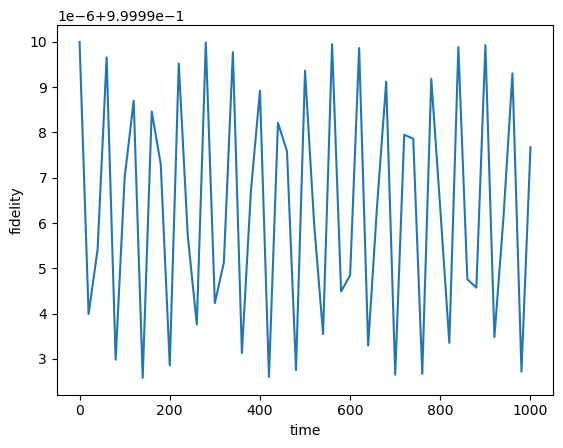

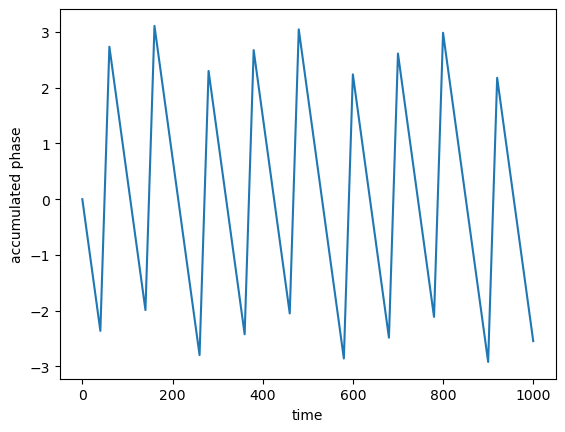

In [9]:
fig, ax = plt.subplots()
ax.plot(tvec, fidelity_vec)

ax.set_xlabel(r"time")
ax.set_ylabel(r"fidelity")
plt.show()

fig, ax = plt.subplots()
ax.plot(tvec, phase_t)

ax.set_xlabel(r"time")
ax.set_ylabel(r"accumulated phase")
plt.show()

# Counterdiabatic Evolutions

In [10]:
theta=np.pi/3
E=1
T=1
omega=(2*np.pi)/T

dyn_phase=E*T
geom_phase=-2*np.pi*np.sin(theta/2)**2

psi_plus = np.array([np.cos(theta/2), np.sin(theta/2)], dtype=np.complex128)

tvec = np.linspace(0, T, 51)

# Compute instantaneous eigenstates:
psi_t  = np.zeros((tvec.size, 2), dtype=np.complex128)
psi_t +=  psi_plus[None,:] * 1.
psi_t[:,1] *= np.exp(1j*omega*tvec)

## Kato CD

In [11]:
# Evolve with HCD_Kato:
res_HcdKato = solve_ivp(
    tdse,
    (0,T), # time span
    psi_plus, # initial state
    args=(HcdKato, (theta, omega)),
    method='DOP853',
    rtol=1e-10,
    atol=1e-10,
    t_eval=tvec,
)


states_t = res_HcdKato.y.copy()

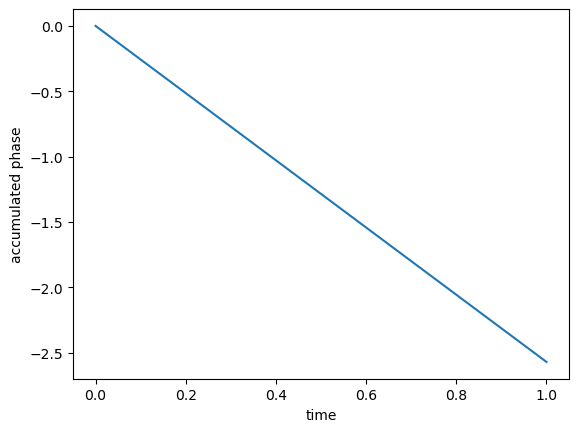

-2.5707963268359575
-2.570796326794896


In [12]:
fidelity_vec = np.abs(np.einsum(
    "it, ti -> t",
    states_t,
    psi_t.conj(),
    optimize=True
))**2
assert np.allclose(1.+0j, fidelity_vec)
phase_t = np.angle( np.einsum(
    "it, ti -> t",
    states_t,
    psi_t.conj(),
    optimize=True
))

fig, ax = plt.subplots()
ax.plot(tvec, phase_t)

ax.set_xlabel(r"time")
ax.set_ylabel(r"accumulated phase")
plt.show()

print( phase_t[-1])
print( -dyn_phase+geom_phase)

## Kato AGP only

In [13]:
# Evolve with HCD_Kato:
res_agpKato = solve_ivp(
    tdse,
    (0,T), # time span
    psi_plus, # initial state
    args=(agpKato, (theta, omega)),
    method='DOP853',
    rtol=1e-10,
    atol=1e-10,
    t_eval=tvec,
)


states_t = res_agpKato.y.copy()

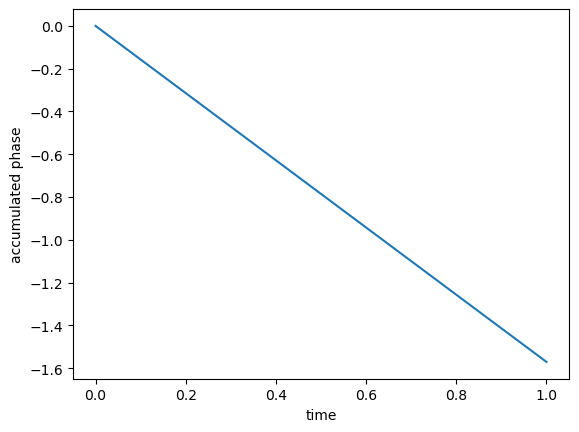

-1.5707963268474003
-1.5707963267948961


In [14]:
fidelity_vec = np.abs(np.einsum(
    "it, ti -> t",
    states_t,
    psi_t.conj(),
    optimize=True
))**2
assert np.allclose(1.+0j, fidelity_vec)
phase_t = np.angle( np.einsum(
    "it, ti -> t",
    states_t,
    psi_t.conj(),
    optimize=True
))

fig, ax = plt.subplots()
ax.plot(tvec, phase_t)

ax.set_xlabel(r"time")
ax.set_ylabel(r"accumulated phase")
plt.show()

print( phase_t[-1])
print( geom_phase)

## Dynamic AGP

In [15]:
# Evolve with HCD:
res_Hcd = solve_ivp(
    tdse,
    (0,T), # time span
    psi_plus, # initial state
    args=(Hcd, (theta, omega)),
    method='DOP853',
    rtol=1e-10,
    atol=1e-10,
    t_eval=tvec,
)

states_t = res_Hcd.y.copy()

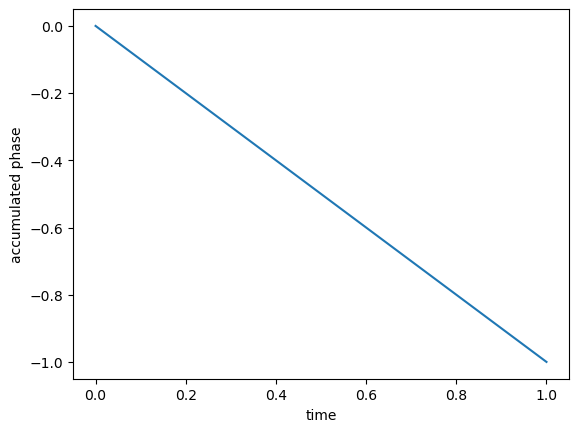

-1.0000000000474192
-1


In [16]:
fidelity_vec = np.abs(np.einsum(
    "it, ti -> t",
    states_t,
    psi_t.conj(),
    optimize=True
))**2
assert np.allclose(1.+0j, fidelity_vec)
phase_t = np.angle( np.einsum(
    "it, ti -> t",
    states_t,
    psi_t.conj(),
    optimize=True
))

fig, ax = plt.subplots()
ax.plot(tvec, phase_t)

ax.set_xlabel(r"time")
ax.set_ylabel(r"accumulated phase")
plt.show()

print( phase_t[-1])
print( -dyn_phase)

## Arbitrary agp

In [17]:
chi_deriv = np.sqrt(2)

# Evolve with HCD:
res_Hcdarb = solve_ivp(
    tdse,
    (0,T), # time span
    psi_plus, # initial state
    args=(Hcd, (theta, omega, chi_deriv)),
    method='DOP853',
    rtol=1e-10,
    atol=1e-10,
    t_eval=tvec,
)

states_t = res_Hcdarb.y.copy()

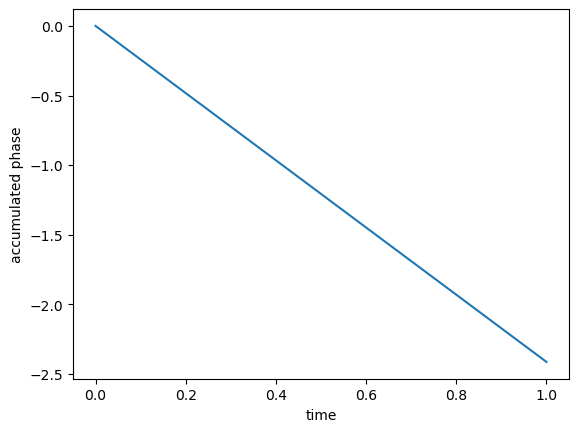

-2.4142135624358203
-2.414213562373095


In [18]:
fidelity_vec = np.abs(np.einsum(
    "it, ti -> t",
    states_t,
    psi_t.conj(),
    optimize=True
))**2
assert np.allclose(1.+0j, fidelity_vec)
phase_t = np.angle( np.einsum(
    "it, ti -> t",
    states_t,
    psi_t.conj(),
    optimize=True
))

fig, ax = plt.subplots()
ax.plot(tvec, phase_t)

ax.set_xlabel(r"time")
ax.set_ylabel(r"accumulated phase")
plt.show()

print( phase_t[-1])
print( -dyn_phase - chi_deriv*T)